In [1]:
%run "000_shared.ipynb"

# Prorocessing Steps
1. Equalize << TODO: Choose method based on imaging modality traits 
    - Equalize
        - CLAHE: too harsh
        - Contrast stretching: seems fine 
    - Resize 
    - Retype - norm/255 and float type 

2. Pull out color channels <<TODO: explore for relevance of each. 
    - Green: has details. Better than gray 
    - Red: has intensities = r>threshold. Filter for pth percentile --> ?thin layer, hottest??<< TODO: yellow pigmentation goes where 
    - Blue: seems to carry texture information but still not sure = b==1. The pixels seem to be fully turned on. 
    - Output new map of these channels
    - Metrics: proption of red mask and blue mask pixels and findng some pattern/thresh, blobs counts??

3. Pull out veins mask 
    - Frangi vesselness should do. 
    - Output += veins mask
    - Metrics: proportion of veins --> cataracts OR DR,AMD,MA,HM 



In [9]:
## TODO: generalize 
import glob, os 
# from skimage import filters, io
# io.use_plugin('freeimage')
from skimage import img_as_float

import pickle 

class Preprocessor:
    dir_output = "output"
    dir_feature_maps = "fmaps"
    dir_progress_maps = "progress"
    fmap_ext = ".fmap"
    
    def __init__(self):
        dz = [self.dir_output, 
              f"{self.dir_output}/{self.dir_feature_maps}", 
              f"{self.dir_output}/{self.dir_progress_maps}"]
        ## TODO: pathlib 
        for d in dz:
            if not os.path.exists(d):
                os.makedirs(d)
    
    ## Pipeline = folder --> subsets --> file --> AnImage --> eq --> colormaps --> vessels --> save --> plot/report     
    def load_stare_fundus_dir(self, 
                              fdir="../../data/stare_fundus", ext='ppm',
                              dcodes_txt="disease_codes.txt",
                              data_labelz_txt="all-mg-codes.txt"):
        self.fdir = fdir         
        self.dataset = sorted(glob.glob( f"{self.fdir}/*.{ext}") )
        
        def load_txt(fname, outds):
            with open(f"{self.fdir}/{fname}", 'r') as fd:
                for f in fd.readlines():
                    rec = f.split("\t") 
                    #print(rec[0], ": ", [x.strip() for x in rec[1:] if len(x) > 0])
                    outds[rec[0]] = [x.strip() for x in rec[1:] if len(x) > 0]

        
        self.disease_codez = {}        
        self.data_labelz = {}
        load_txt( dcodes_txt, self.disease_codez) 
        load_txt( data_labelz_txt, self.data_labelz) 
        
    @property
    def dataset_size(self):
        return len(self.dataset)
    
    def image_rescale_retype(self, img):
        outiez = img.copy()
        outiez = outiez/255 ## assuming that's how they come in 
        outiez = img_as_float(outiez)
        return outiez
    
    def resize_image(self, img):
        pass 
    
    
    def run_pipeline(self, n=None):
        for i, ipath in enumerate(self.dataset):
            try:
                fname = os.path.splitext( os.path.basename(ipath) )[0]
                fout = f"{self.dir_output}/{self.dir_feature_maps}/{fname}{self.fmap_ext}"
                fprog = f"{self.dir_output}/{self.dir_progress_maps}"

                print(f"{i}: Starting on {fname}", end=", ")
                # 1. get image from file 
                outsiez_prog = []
                anImg = AnImage(ipath)      
                # 1b. rescale and retype
                anImg.image = self.image_rescale_retype(anImg.image)
                # 1c. resize image 
                anImg.image = self.resize_image(anImg.image)
                
                # 2. equalize 
                anImg.image = self.equalize_image(anImg.image) 
                print(f"equalized", end=", ")
                # 3. vessels map << run on green Vs gray
                outsiez_prog.append( self.vessels_map_image(anImg.green))  
                print(f"vessels mapped", end=", ")
                # 4. color maps: green-details, red-intensity, blue-texture
                outsiez_prog.append( self.green_channel_update(anImg.green) )
                outsiez_prog.append( self.red_channel_update(anImg.red) )
                outsiez_prog.append( self.blue_channel_update(anImg.blue) )
                print(f"colors mapped", end=", ") 
                
                # 5. combine and save << combine color maps separately first 
                outiez = self.combine_channelz(list(outsiez_prog[1:]))
                outsiez_prog.append( outiez) #outiez[:,:,1:])         
                #outiez = self.combine_channelz(list(outsiez_prog))    
                #skimage.io.imsave(fout, outiez)
                #self.save_fmap(fout, outiez)
                self.save_fmap(fout, outsiez_prog)
                print(f"combined and saved", end=", ")

                # 6. save progress imagez 
                def get_disease_code(fn):
                    lbz = self.data_labelz[fn][0].split(" ")
                    dlbl = []
                    for l in lbz:
                        d = self.disease_codez.get(l, None)
                        if d:
                            dlbl.append(d[1].strip())
                    return "-".join(dlbl)


                tx = ['vessels', 'green', 'red', 'blue', 'combo']
                AnImage.plot_images_list(outsiez_prog+[-im for im in outsiez_prog], 
                                         titlez=tx, 
                                         nc=len(outsiez_prog), 
                                         cmap='gray', 
                                         save=f'{fname}_{get_disease_code(fname)}',
                                         tdir=fprog,
                                         withist=False)            
                print("\n")
            except:
                pass 
            
            if (n is not None) and (i==n):
                break
    
    def save_fmap(self, fpath, fmap):
        with open(fpath, 'wb') as fd:
            pickle.dump(fmap, fd)
            
    def open_fmap(self, fpath):
        with open(fpath, 'rb') as fd:
            return pickle.load(fd)
    
    def get_image_i(self, idx):
        return AnImage( self.dataset[idx] ) 
    
    def equalize_image(self, img):
        ## == TODO: choice at img traits 
        # a. adaptive histogram equalization update
        #outsiez = exposure.equalize_adapthist(img, clip_limit=0.03)
        # b. OR contrast stretching 
        p2, p98 = np.percentile(img, (2,98))
        outsiez = skimage.exposure.rescale_intensity(img, in_range=(p2,p98))
        
        return outsiez
    
    def vessels_map_image(self, img):
        ## == TODO: tweak for performance 
        ## frangi vesselness << expects grayscale img 
        kwargs = {'sigmas': [1], 'mode': 'reflect', 'black_ridges': 0}
        outsiez = skimage.filters.frangi(img) #, **kwargs)        
        return outsiez 
    
    def green_channel_update(self, img):
        return img.copy()  
    
    def red_channel_update(self, img, thresh=0.97):
        outsiez = img.copy()
        red_range = outsiez.max() - outsiez.min()       
        outsiez[( (outsiez-outsiez.min())/red_range) < thresh] = 0      
        #outsiez = outsiez*-1        
        return outsiez        
    
    def blue_channel_update(self, img, thresh=1):
        outsiez = img.copy()
        outsiez[outsiez != 1] = 0         
        return outsiez
    
    def combine_channelz(self, cimagez):
        outsiez = np.dstack( cimagez)        
        return outsiez 
    
    
    def explorer(self, num=None,):
        fprog = f"{self.dir_output}/{self.dir_progress_maps}" ## DIR        
        
        n = self.dataset_size   
        if num is None:
            samples = range(n)
        else:      
            samples = np.random.randint(0, n, size=num)
            
        for i in samples:
            try:
                ipath = self.dataset[i]
                fname = os.path.splitext( os.path.basename(ipath) )[0]

                print(f"{i}: Starting on {fname}", end=", ")
                # 1. get image from file 
                outsiez_prog = []
                anImg = AnImage(ipath)             
                # 2. equalize 
                anImg.image = self.equalize_image(anImg.image) 
                print(f"equalized", end=", ")
                outsiez_prog.append(anImg.green)
                outsiez_prog.append(anImg.red)
                outsiez_prog.append(anImg.blue)
                outsiez_prog.append( -self.red_channel_update(anImg.red) )
                outsiez_prog.append( -self.blue_channel_update(anImg.blue) )

                ### TODO: refactor, reuse 
                # 6. save progress imagez 
                def get_disease_code(fn):
                    lbz = self.data_labelz[fn][0].split(" ")
                    dlbl = []
                    for l in lbz:
                        d = self.disease_codez.get(l, None)
                        if d:
                            dlbl.append(d[1].strip())
                    return "-".join(dlbl)


                tx = ['green', 'red', 'blue', 'r-update', 'b-update']
                AnImage.plot_images_list(outsiez_prog, #[-im for im in outsiez_prog], 
                                         titlez=tx, 
                                         nc=len(outsiez_prog), 
                                         cmap='gray', 
                                         save=f'histo_{fname}_{get_disease_code(fname)}',
                                         tdir=fprog,
                                         withist=True)            
                print("\n")
            except:
                pass 
            
        #return samples

In [3]:
NUM=3
stare_proc = Preprocessor()
stare_proc.load_stare_fundus_dir()

197: Starting on im0203, equalized, 

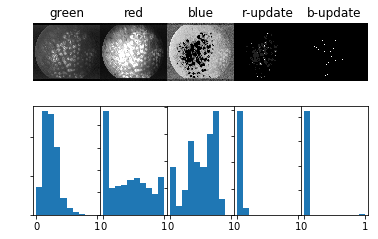



267: Starting on im0273, equalized, 

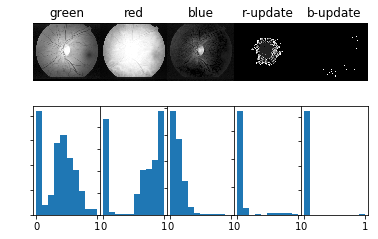



303: Starting on im0309, equalized, 

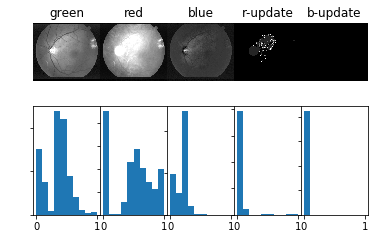

In [10]:
#samples = 
stare_proc.explorer(num=NUM)

In [5]:
stare_proc.run_pipeline(n=NUM)

0: Starting on im0001, 1: Starting on im0002, 2: Starting on im0003, 3: Starting on im0004, 

Checking output/fmaps/im0002.fmap
5


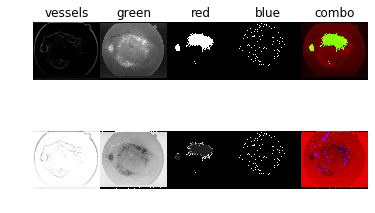

In [6]:
## ===== Loading processed featuremap file ==== 
DATA_DIR = "../../data/stare_fundus"
OUTPUTZ_DIR = "output/fmaps"
im = np.random.randint(0, NUM) #stare_proc.dataset_size 
##TODO: template string fill in the zeroes
im = f'00{im}' if im < 10 else f'0{im}' if im < 100 else f'{im}' 
fpath = f"{OUTPUTZ_DIR}/im0{im}.fmap"

print(f"Checking {fpath}" )

fmap = stare_proc.open_fmap(fpath)
#print(fmap.shape)
print(len(fmap))

# 6. show progress imagez 
tx = ['vessels', 'green', 'red', 'blue', 'combo']
#x = [ fmap[:,:,i] for i in range(len(fmap)) ] #+ [ fmap[:,:,4:] ]  #len(fmap-2)
x = [ fmap[i] for i in range(len(fmap)) ]
AnImage.plot_images_list(x+[-i for i in x], 
                         titlez=tx, 
                         nc=len(x), 
                         cmap='gray', 
                         save=None)  